In [1]:
from utz import *
from datetime import timedelta

In [2]:
df = concat([ read_parquet(f'data/{year}.pqt') for year in range(2012, 2024) ])
df

avg daily  avg weekday  avg sat  avg sun  \
month      station                                                         
2012-01-01 Christopher Street        3619         4256     2708     2433   
           9thStreet                 4087         4483     3695     3436   
           14thStreet                7370         8768     5346     4730   
           23rdStreet                6374         8345     2924     2563   
           33rdStreet               28586        34797    17350    16716   
...                                   ...          ...      ...      ...   
2023-10-01 Exchange Place            8650        10544     4949     3993   
           Pavonia/ Newport         10414        12756     5627     4567   
           Hoboken                  14452        17486     8994     6781   
           NEW JERSEY SUBTOTAL      84726       101966    51829    41461   
           MONTHLY TOTAL           154725       185148    95919    79249   

                                avg holiday    total  total weekday  \
month      station                                                    
2012-01-01 Christopher Street          2040   112187          85113   
           9thStreet                   2533   126682          89658   
           14thStreet                  4041   228483         175369   
           23rdStreet                  3096   197597         166895   
           33rdStreet                 18627   886167         695937   
...                                     ...      ...            ...   
2023-10-01 Exchange Place              6970   268150         221420   
           Pavonia/ Newport            9605   322826         267876   
           Hoboken                    10936   448025         367211   
           NEW JERSEY SUBTOTAL        70579  2626497        2141298   
           MONTHLY TOTAL             128467  4796487        3888101   

                                total sat  total sun  total holiday  
month      station                                                   
2012-01-01 Christopher Street       10830      12163           4081  
           9thStreet                14780      17178           5066  
           14thStreet               21384      23648           8082  
           23rdStreet               11698      12813           6191  
           33rdStreet               69398      83578          37254  
...                                   ...        ...            ...  
2023-10-01 Exchange Place           19796      19964           6970  
           Pavonia/ Newport         22508      22837           9605  
           Hoboken                  35974      33904          10936  
           NEW JERSEY SUBTOTAL     207316     207304          70579  
           MONTHLY TOTAL           383676     396243         128467  

[2414 rows x 10 columns]

In [3]:
force = False
default_show = 'png'
W = 1200
H = 600
end_month = '2023-11'

In [4]:
path = 'data/all.pqt'
if force or not exists(path):
    df.to_parquet(path)

path = 'data/all.xlsx'
if force or not exists(path):
    df.to_excel(path)

In [5]:
df = df.reset_index()
df = df[~df.station.str.contains('TOTAL')]
df

,month,station,avg daily,avg weekday,avg sat,avg sun,avg holiday,total,total weekday,total sat,total sun,total holiday
0,2012-01-01,Christopher Street,3619,4256,2708,2433,2040,112187,85113,10830,12163,4081
1,2012-01-01,9thStreet,4087,4483,3695,3436,2533,126682,89658,14780,17178,5066
2,2012-01-01,14thStreet,7370,8768,5346,4730,4041,228483,175369,21384,23648,8082
3,2012-01-01,23rdStreet,6374,8345,2924,2563,3096,197597,166895,11698,12813,6191
4,2012-01-01,33rdStreet,28586,34797,17350,16716,18627,886167,695937,69398,83578,37254
...,...,...,...,...,...,...,...,...,...,...,...,...
2407,2023-10-01,Journal Square,18208,21261,12659,10210,16280,564441,446476,50637,51048,16280
2408,2023-10-01,Grove Street,14103,16392,10452,7988,11213,437200,344237,41809,39941,11213
2409,2023-10-01,Exchange Place,8650,10544,4949,3993,6970,268150,221420,19796,19964,6970
2410,2023-10-01,Pavonia/ Newport,10414,12756,5627,4567,9605,322826,267876,22508,22837,9605


In [6]:
df[df.month == '2012-03-01']

,month,station,avg daily,avg weekday,avg sat,avg sun,avg holiday,total,total weekday,total sat,total sun,total holiday
34,2012-03-01,Christopher Street,4164,4676,3156,2608,0,129084,102868,15782,10434,0
35,2012-03-01,9thStreet,4899,5245,4465,3538,0,151861,115384,22327,14150,0
36,2012-03-01,14thStreet,8537,9656,6487,4948,0,264651,212422,32435,19794,0
37,2012-03-01,23rdStreet,7039,8699,3353,2512,0,218202,191387,16766,10049,0
38,2012-03-01,33rdStreet,31788,37091,21313,15717,0,985438,816005,106564,62869,0
40,2012-03-01,WTC,40649,51310,15948,12887,0,1260117,1128828,79741,51548,0
42,2012-03-01,Newark,26589,32728,13480,9211,0,824255,720014,67398,36843,0
43,2012-03-01,Harrison,6308,7532,3673,2871,0,195559,165711,18365,11483,0
44,2012-03-01,Journal Square,24377,28523,16374,11577,0,755692,627513,81871,46308,0
45,2012-03-01,Grove Street,14103,16644,9247,6202,0,437208,366163,46235,24810,0


In [7]:
month_totals = df.drop(columns='station').groupby('month').sum()
months = month_totals.index.to_series().dt
month_idxs = months.month.rename('month_idx')
years = months.year.rename('year')
month_totals = sxs(years, month_idxs, month_totals)
month_totals

,year,month_idx,avg daily,avg weekday,avg sat,avg sun,avg holiday,total,total weekday,total sat,total sun,total holiday
month,,,,,,,,,,,,
2012-01-01,2012,1,197685,252769,107207,86186,106548,6128233,5055387,428830,430920,213096
2012-02-01,2012,2,212117,261474,114891,86595,116023,6151419,5229454,459565,346377,116023
2012-03-01,2012,3,224294,269793,129974,91947,0,6953140,5935471,649878,367791,0
2012-04-01,2012,4,214848,260699,132476,88181,0,6445477,5474674,529898,440905,0
2012-05-01,2012,5,217887,261234,129288,99553,91973,6754485,5747143,517147,398222,91973
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,2023,6,142349,164558,98563,80338,99089,4270443,3455759,394246,321349,99089
2023-07-01,2023,7,133935,162385,95178,70347,76602,4151953,3247724,475889,351738,76602
2023-08-01,2023,8,142965,162577,99662,73517,0,4431962,3739251,398646,294065,0


In [8]:
def rnd(n, ε=.01):
    if isna(n):
        return n
    N = round(n)
    err = max(n, N) / min(n, N) - 1
    if err > ε:
        raise ValueError(f'{n} too far from {N} (ε: {ε})')
    return N

num_week = (month_totals['total weekday'] / month_totals['avg weekday']).apply(rnd).rename('num weekdays')
num_sats = (month_totals['total sat'] / month_totals['avg sat']).apply(rnd).rename('num sats')
num_suns = (month_totals['total sun'] / month_totals['avg sun']).apply(rnd).rename('num suns')
num_days = (month_totals['total'] / month_totals['avg daily']).apply(rnd).rename('num days')
num_hols = (month_totals['total holiday'] / month_totals['avg holiday']).apply(rnd).rename('num holidays').fillna(0).astype(int)
nums = sxs(num_week, num_sats, num_suns, num_days, num_hols)
nums['num weekends'] = num_sats + num_suns
nums

,num weekdays,num sats,num suns,num days,num holidays,num weekends
month,,,,,,
2012-01-01,20,4,5,31,2,9
2012-02-01,20,4,4,29,1,8
2012-03-01,22,5,4,31,0,9
2012-04-01,21,4,5,30,0,9
2012-05-01,22,4,4,31,1,8
...,...,...,...,...,...,...
2023-06-01,21,4,4,30,1,8
2023-07-01,20,5,5,31,1,10
2023-08-01,23,4,4,31,0,8


In [9]:
m = df.merge(nums, how='left', left_on='month', right_index=True)
df['avg weekend'] = round((df['total sat'] + df['total sun']) / m['num weekends']).astype(int)
cols = df.columns.tolist()
df = df[cols[:4] + ['avg weekend'] + cols[4:-1]]
df

,month,station,avg daily,avg weekday,avg weekend,avg sat,avg sun,avg holiday,total,total weekday,total sat,total sun,total holiday
0,2012-01-01,Christopher Street,3619,4256,2555,2708,2433,2040,112187,85113,10830,12163,4081
1,2012-01-01,9thStreet,4087,4483,3551,3695,3436,2533,126682,89658,14780,17178,5066
2,2012-01-01,14thStreet,7370,8768,5004,5346,4730,4041,228483,175369,21384,23648,8082
3,2012-01-01,23rdStreet,6374,8345,2723,2924,2563,3096,197597,166895,11698,12813,6191
4,2012-01-01,33rdStreet,28586,34797,16997,17350,16716,18627,886167,695937,69398,83578,37254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2407,2023-10-01,Journal Square,18208,21261,11298,12659,10210,16280,564441,446476,50637,51048,16280
2408,2023-10-01,Grove Street,14103,16392,9083,10452,7988,11213,437200,344237,41809,39941,11213
2409,2023-10-01,Exchange Place,8650,10544,4418,4949,3993,6970,268150,221420,19796,19964,6970
2410,2023-10-01,Pavonia/ Newport,10414,12756,5038,5627,4567,9605,322826,267876,22508,22837,9605


In [10]:
month_totals['avg weekend'] = round((month_totals['total sat'] + month_totals['total sun']) / nums['num weekends']).astype(int)
cols = month_totals.columns.tolist()
month_totals = month_totals[cols[:4] + ['avg weekend'] + cols[4:-1]]
month_totals

,year,month_idx,avg daily,avg weekday,avg weekend,avg sat,avg sun,avg holiday,total,total weekday,total sat,total sun,total holiday
month,,,,,,,,,,,,,
2012-01-01,2012,1,197685,252769,95528,107207,86186,106548,6128233,5055387,428830,430920,213096
2012-02-01,2012,2,212117,261474,100743,114891,86595,116023,6151419,5229454,459565,346377,116023
2012-03-01,2012,3,224294,269793,113074,129974,91947,0,6953140,5935471,649878,367791,0
2012-04-01,2012,4,214848,260699,107867,132476,88181,0,6445477,5474674,529898,440905,0
2012-05-01,2012,5,217887,261234,114421,129288,99553,91973,6754485,5747143,517147,398222,91973
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,2023,6,142349,164558,89449,98563,80338,99089,4270443,3455759,394246,321349,99089
2023-07-01,2023,7,133935,162385,82763,95178,70347,76602,4151953,3247724,475889,351738,76602
2023-08-01,2023,8,142965,162577,86589,99662,73517,0,4431962,3739251,398646,294065,0


In [11]:
month_totals[month_totals.year == 2012]

,year,month_idx,avg daily,avg weekday,avg weekend,avg sat,avg sun,avg holiday,total,total weekday,total sat,total sun,total holiday
month,,,,,,,,,,,,,
2012-01-01,2012,1,197685,252769,95528,107207,86186,106548,6128233,5055387,428830,430920,213096
2012-02-01,2012,2,212117,261474,100743,114891,86595,116023,6151419,5229454,459565,346377,116023
2012-03-01,2012,3,224294,269793,113074,129974,91947,0,6953140,5935471,649878,367791,0
2012-04-01,2012,4,214848,260699,107867,132476,88181,0,6445477,5474674,529898,440905,0
2012-05-01,2012,5,217887,261234,114421,129288,99553,91973,6754485,5747143,517147,398222,91973
2012-06-01,2012,6,220583,265070,116770,125922,105328,0,6617439,5566513,629613,421313,0
2012-07-01,2012,7,215812,265126,109675,124534,97788,135395,6690150,5567676,498137,488942,135395
2012-08-01,2012,8,219127,256280,112315,124030,100598,0,6792920,5894399,496124,402397,0
2012-09-01,2012,9,211823,267481,117874,131998,103752,93810,6354673,5082119,659987,518757,93810


In [12]:
from calendar import month_abbr
pivoted = (
    month_totals
    .assign(month=month_totals.month_idx.apply(lambda m: month_abbr[m]))
    .set_index(['month_idx', 'month'])
    [['year', 'avg weekday', 'avg weekend', 'avg sat', 'avg sun']]
    .pivot(columns='year')
    .replace(nan, 0).astype(int)
    .sort_index()
    .reset_index(level=0, drop=True)
)
pivoted

avg weekday                                                          \
year         2012    2013    2014    2015    2016    2017    2018    2019   
month                                                                       
Jan        252769  217347  231474  227561  250485  266846  266614  272334   
Feb        261474  233634  233112  245225  259235  266278  279694  278046   
Mar        269793  235594  248144  250489  265131  266744  264985  281604   
Apr        260699  248689  252737  258354  270123  289352  284284  285928   
May        261234  249230  255113  264328  271904  284093  291747  289413   
Jun        265070  252260  259002  267051  277947  288215  291075  292317   
Jul        265126  250019  258041  267494  272797  297494  281776  288162   
Aug        256280  245527  250156  259296  269440  297000  275442  281487   
Sep        267481  256738  258152  269042  278139  293422  289129  298518   
Oct        233819  259233  262366  274486  276416  297032  299788  296977   
Nov        121496  252038  253716  268329  277473  291558  287651  290128   
Dec        185834  233064  237434  248433  258948  265519  258220  257960   

                                      avg weekend                          \
year     2020    2021    2022    2023        2012    2013    2014    2015   
month                                                                       
Jan    277232   56904   84185  145636       95528   71794   82017   78583   
Feb    282852   52604  113248  150238      100743   76570   94185   82079   
Mar    126408   64332  132441  155241      113074   99112   92322   92511   
Apr     14597   70157  135339  161953      107867  105666   97936  106301   
May     20447   79652  140303  171363      114421  101889  101516  107425   
Jun     34366   91755  148025  164558      116770  109826  101138  107012   
Jul     47027   99232  138960  162385      109675  101328   95779  104195   
Aug     54124   98423  138504  162577      112315  109008   93828  107570   
Sep     62651  113599  157982  178946      117874  109078   96406  109970   
Oct     65841  124727  158481  185147      114902  109497   95562  110087   
Nov     61755  128095  155527       0       43762   99845   89674  102266   
Dec     55354  112664  139597       0       69253  103426  101367  111703   

                                                                  avg sat  \
year     2016    2017    2018    2019   2020   2021   2022   2023    2012   
month                                                                       
Jan     77728   86785   85625   73360  74503  30711  42657  69586  107207   
Feb     89792   95271   88136   81987  82704  32741  60742  69142  114891   
Mar    101323   92524  103004   87887  36523  40567  64201  74664  129974   
Apr    104506  107947  103954   96568   6935  44542  74555  77752  132476   
May    101678  101782  100587   97908  10891  50145  71893  89091  129288   
Jun    107583  111428  110272  101676  18902  65780  82836  89449  125922   
Jul    101454  106582   91842   90233  25766  65200  75270  82763  124534   
Aug     87769  107192   88646   98577  30635  59512  77925  86589  124030   
Sep     96233  111447   96501  101705  38917  73652  86048  83802  131998   
Oct     88010  107386   89491   96709  41379  74408  82763  86658  137725   
Nov     91880  101310  100141   93909  35455  73318  80947      0   49610   
Dec     90492  103127  111746  107070  31694  66333  73965      0   77425   

                                                                             \
year     2013    2014    2015    2016    2017    2018    2019   2020   2021   
month                                                                         
Jan     81710   91282   88875   87876   97008  100665   84349  81647  36228   
Feb     83702  109729   94726  102089  110189  101733   94429  92490  39547   
Mar    118284  110695  107723  119979  107588  118685  106134  38194  49565   
Apr    122783  112771  122707  117505  121897  127001  113328   

In [13]:
import plotly.express as px
from IPython.display import Image

In [14]:
gridcolor = '#ccc'

def default_plot(fig):
    return (
        fig
        .update_layout(
            title_x=0.5,
            paper_bgcolor='white',
            plot_bgcolor='white',
            legend=dict(traceorder='reversed'),
            hovermode='x',
        ).update_xaxes(
            tickangle=-45,
            gridcolor=gridcolor,
        ).update_traces(
            hovertemplate=None,
        ).update_yaxes(
            gridcolor=gridcolor,
            hoverformat=",",
        )
    )

In [15]:
def stations_stack(
    y, title, name=None,
    start=None, end=None,
    dtick=None, tickangle=-45,
    width=W, height=H,
    show=default_show,
):
    if isinstance(start, str):
        start = to_dt(start)
    start = start or to_dt('2012')
    start -= timedelta(days=15)
    if isinstance(end, str):
        end = to_dt(end)
    end = end or to_dt(end_month)
    end -= timedelta(days=15)
    fig = default_plot(
        px.bar(
            df,
            x='month', y=y, color='station',
            title=title,
            labels={
                'station': 'Station',
                y: title,
                'month': 'Month',
            }
        )
    ).update_xaxes(
        range=[start, end],
        dtick=dtick,
    )
    dims = dict(width=width, height=height)
    if name:
        path = f'img/{name}.png'
        print(f'Saving {path}')
        fig.write_image(path, **dims)
    return Image(fig.to_image(**dims)) if show == 'png' else fig

Saving img/weekdays.png


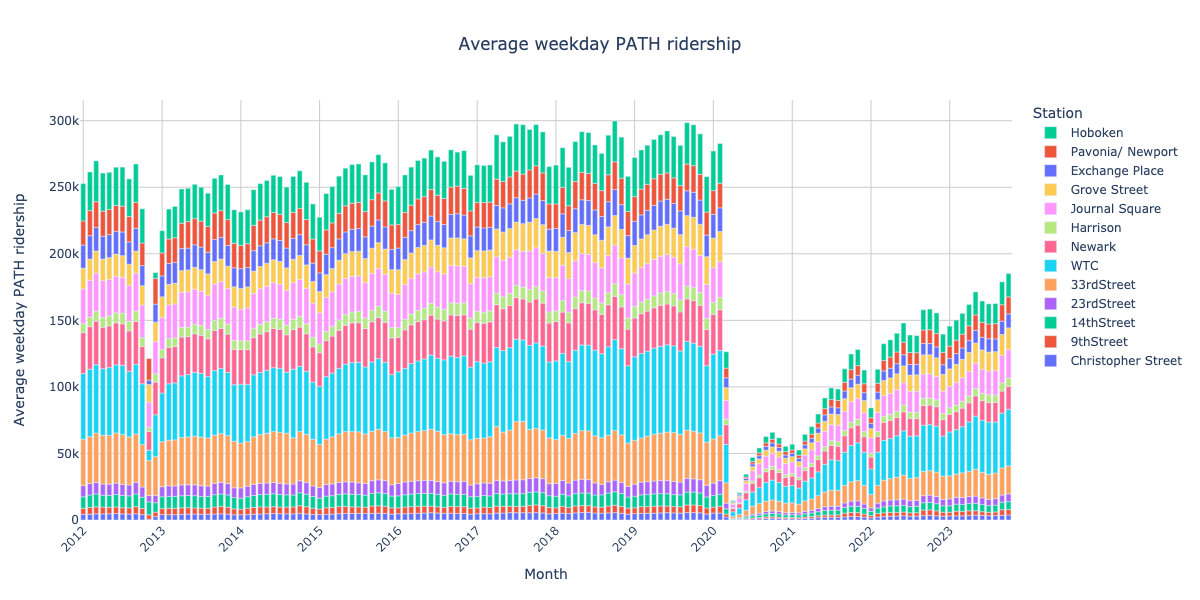

In [16]:
stations_stack(
    'avg weekday',
    'Average weekday PATH ridership',
    dtick="M12",
    name='weekdays',
)

Saving img/weekdays_2020:.png


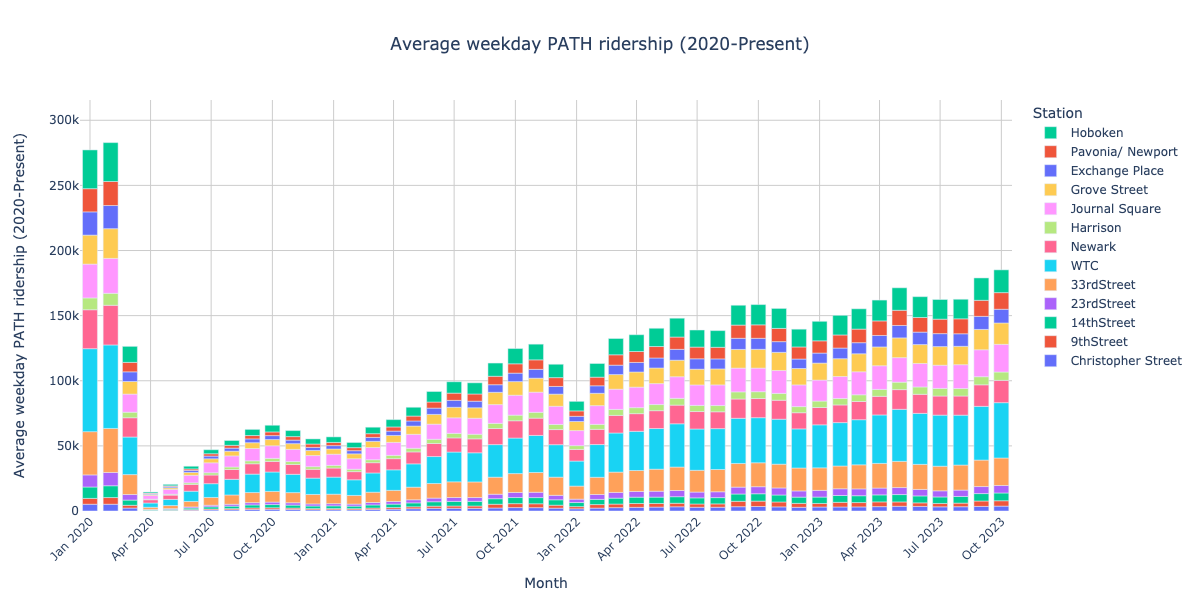

In [17]:
stations_stack(
    'avg weekday',
    'Average weekday PATH ridership (2020-Present)',
    name='weekdays_2020:',
    dtick='M3',
    start='2020',
)

Saving img/weekends.png


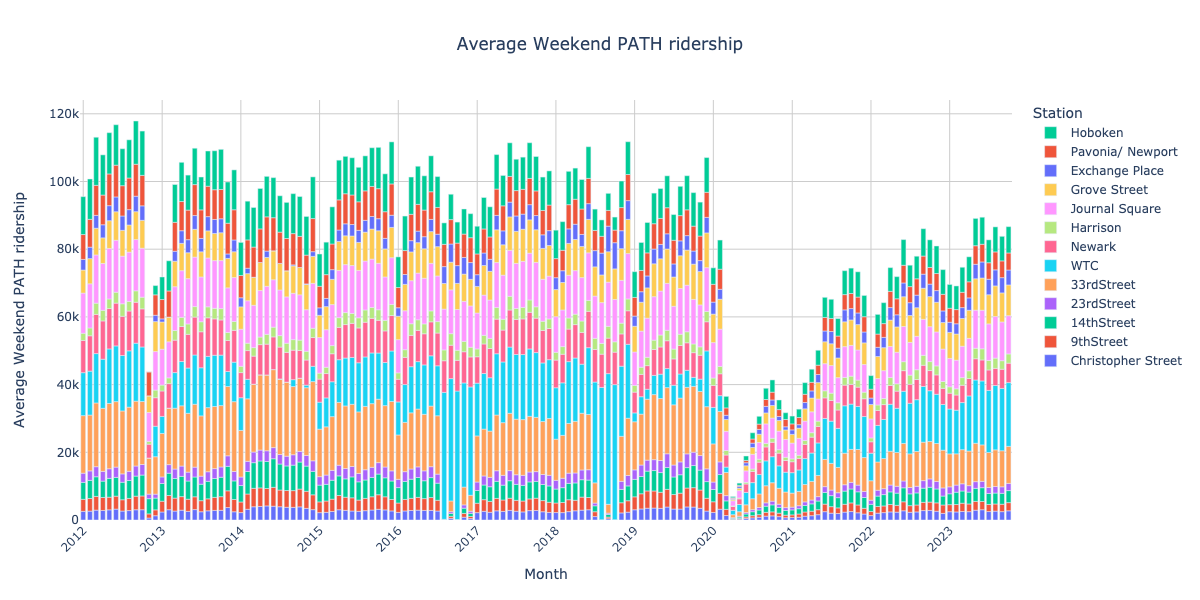

In [18]:
stations_stack(
    'avg weekend',
    'Average Weekend PATH ridership',
    dtick="M12",
    name='weekends',
)

Saving img/weekends_2020:.png


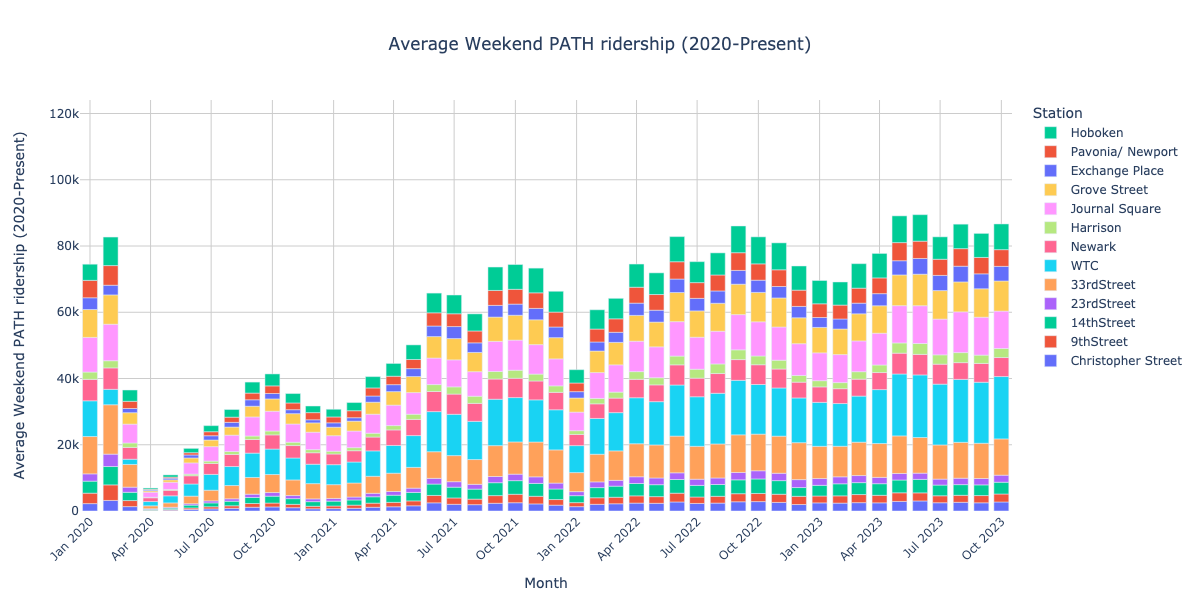

In [19]:
stations_stack(
    'avg weekend',
    'Average Weekend PATH ridership (2020-Present)',
    dtick="M3",
    name='weekends_2020:',
    start='2020',
)

In [20]:
num_years = len(month_totals.year.unique())
num_years

12

In [21]:
from utz.colors import colors_lengthen

In [22]:
px_colors = px.colors.sequential.Inferno
colors = list(reversed(colors_lengthen(px_colors, num_years)))
colors

['#fcffa4',
 '#f7d94f',
 '#f9ae1a',
 '#f48414',
 '#e45e2d',
 '#cb4148',
 '#a82e5d',
 '#842069',
 '#5e136b',
 '#380c5b',
 '#160935',
 '#000004']

In [23]:
month_names = [ to_dt('2022-%02d' % i).strftime('%b') for i in range(1, 13) ]
print(' '.join(month_names))

Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec


In [24]:
def grouped_month_plot(y, title, width=W, height=H, show=default_show):
    fig = px.bar(
        month_totals,
        x='month_idx', y=y,
        color=month_totals.year.astype(str),
        color_discrete_sequence=colors,
        labels={
            'color': 'Year',
            'month_idx': 'Month',
            y: title,
        },
        barmode='group',
    )
    fig = fig.update_layout(
        title=f'{title} (grouped by month)',
        title_x=0.5,
        xaxis=dict(
            tickmode = 'array',
            tickvals = list(range(1, 13)),
            ticktext = month_names,
        ),
    )
    path = f'img/{y}_month_grouped.png'
    dims = dict(width=width, height=height)
    fig.write_image(path, **dims)
    return Image(fig.to_image(**dims)) if show == 'png' else fig

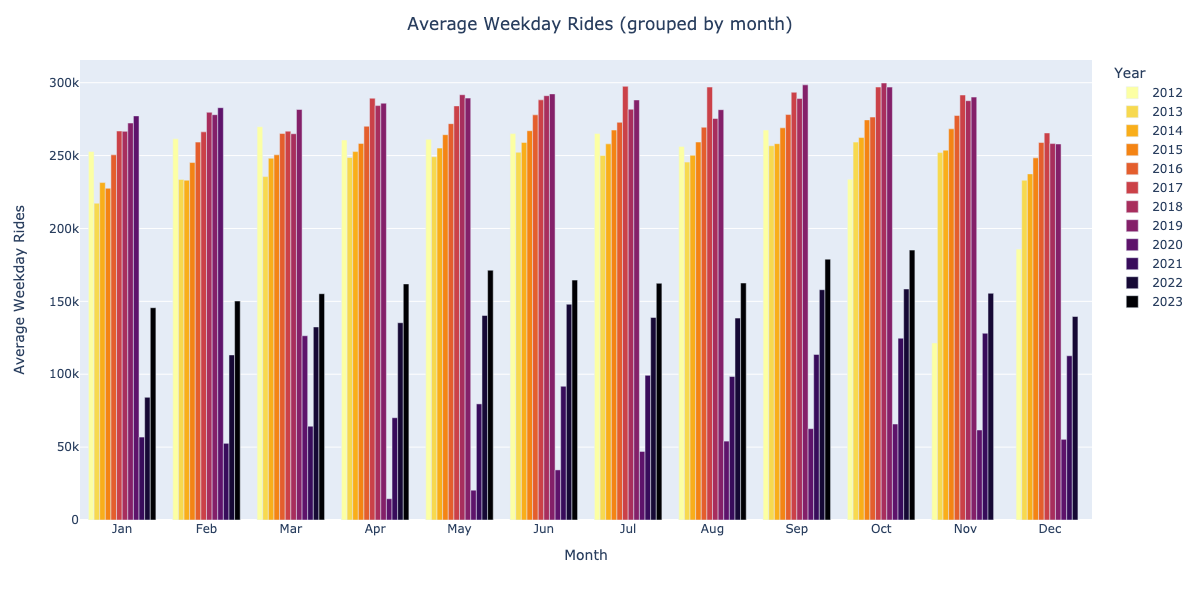

In [25]:
grouped_month_plot('avg weekday', 'Average Weekday Rides')

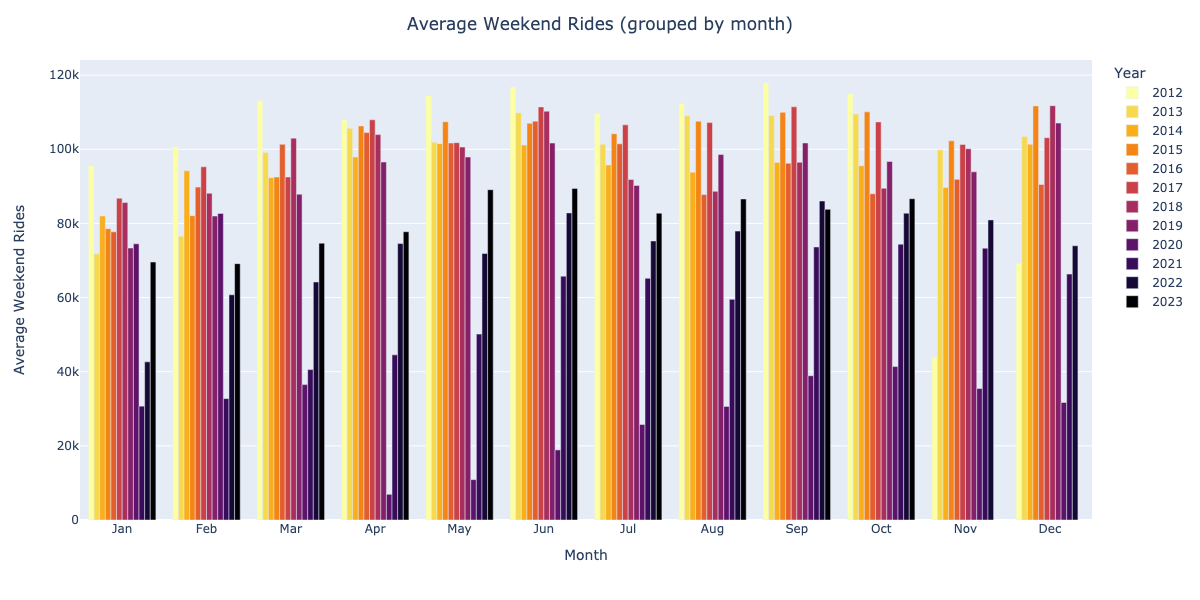

In [26]:
grouped_month_plot('avg weekend', 'Average Weekend Rides')

In [27]:
def lines(df, title, xaxis, name, xtick=None, ytick=None, width=W, height=H, show=default_show):
    fig = default_plot(
        px.line(
            df,
            title=title,
            labels={
                'variable': '',
                'value': xaxis,
                'month': 'Month',
            }
        )
    ).update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    )).update_xaxes(
        dtick=xtick,
        #ticklabelmode="period",
    )
    if ytick:
        fig.update_yaxes(dtick=ytick)
    dims = dict(width=width, height=height)
    fig.write_image(f'img/{name}.png', **dims)
    return Image(fig.to_image(**dims)) if show == 'png' else fig

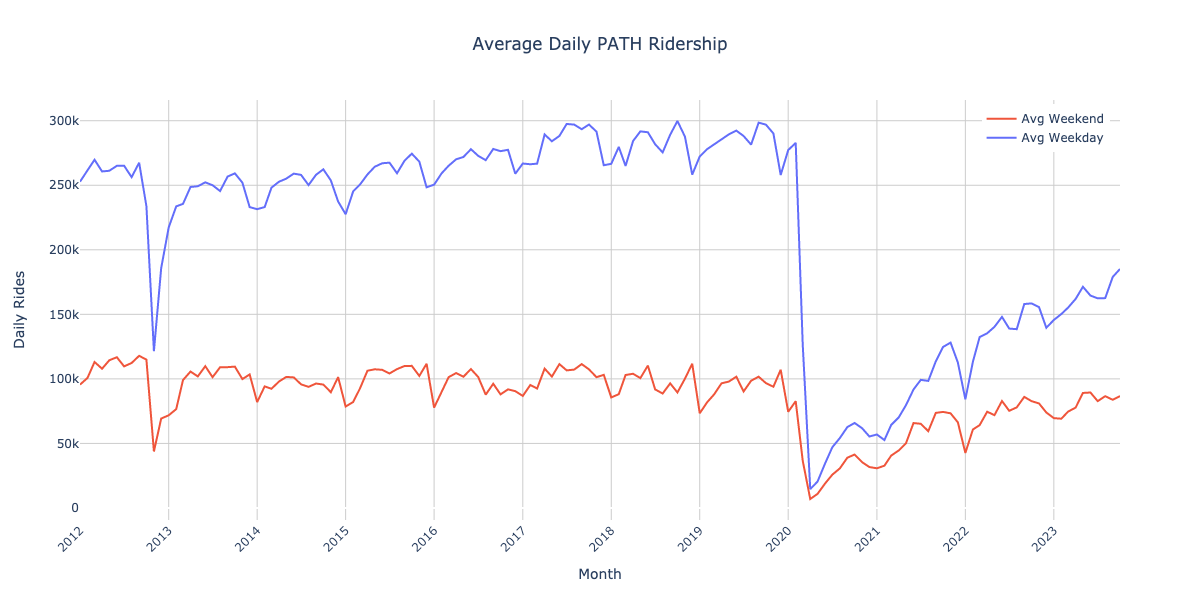

In [28]:
lines(
    month_totals[['avg weekday', 'avg weekend',]].rename(columns={
        'avg weekday': 'Avg Weekday',
        'avg weekend': 'Avg Weekend',
    }),
    title='Average Daily PATH Ridership',
    xaxis='Daily Rides',
    xtick="M12",
    name='avg_day_types',
)

## 2020-2022 Ridership vs. 2019

In [29]:
mt20 = month_totals[month_totals.index >= to_dt('2020')]
mt19 = month_totals[month_totals.year == 2019]
mt19s = pd.concat([ mt19 for i in range((len(mt20) + len(mt19) - 1) // len(mt19)) ]).iloc[:len(mt20)]

keys = ['avg weekday', 'avg weekend']
cmp19 = (
    sxs(
        mt19s.reset_index(drop=True)[keys].rename(columns={ key: f'{key} 2019' for key in keys }),
        mt20.reset_index()[keys + ['month']],
    )
    .set_index('month')
)
for k in keys:
    cmp19[f'{k} frac'] = cmp19[k] / cmp19[f'{k} 2019']
cmp19

,avg weekday 2019,avg weekend 2019,avg weekday,avg weekend,avg weekday frac,avg weekend frac
month,,,,,,
2020-01-01,272334,73360,277232,74503,1.017985,1.015581
2020-02-01,278046,81987,282852,82704,1.017285,1.008745
2020-03-01,281604,87887,126408,36523,0.448886,0.415568
2020-04-01,285928,96568,14597,6935,0.051051,0.071815
2020-05-01,289413,97908,20447,10891,0.070650,0.111237
2020-06-01,292317,101676,34366,18902,0.117564,0.185904
2020-07-01,288162,90233,47027,25766,0.163196,0.285550
2020-08-01,281487,98577,54124,30635,0.192279,0.310772
2020-09-01,298518,101705,62651,38917,0.209873,0.382646


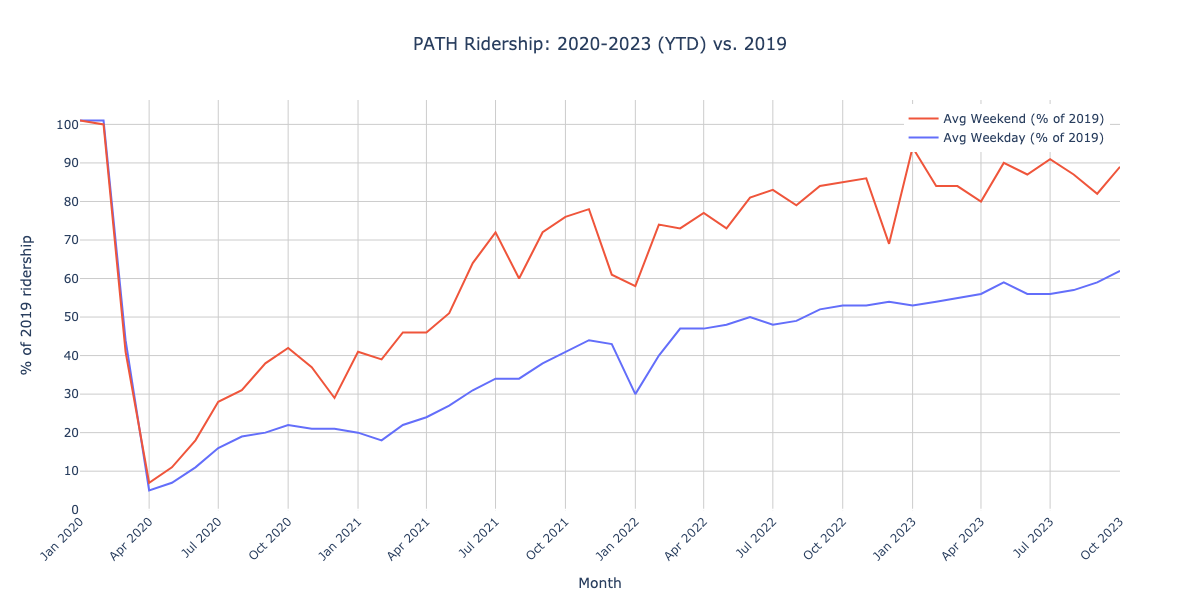

In [30]:
lines(
    (cmp19[[f'{k} frac' for k in keys]] * 100).astype(int).rename(columns={
        'avg weekday frac': 'Avg Weekday (% of 2019)',
        'avg weekend frac': 'Avg Weekend (% of 2019)',
    }),
    title='PATH Ridership: 2020-2023 (YTD) vs. 2019',
    xaxis='% of 2019 ridership',
    xtick="M3",
    ytick=10,
    name='vs_2019',
)